# Vibrational Modes in Atomic Crystals via a Spring System and Perturbations
Imagine an atomic crystal lattice. In such a structure, the bonds can be represented as springs. One of the original ideas for this was devised by Einstein and is thus called an Einstein solid. From quantum mechanics we know that atoms have discrete energy levels due to quantization. These energy levels describe the vibrations of the individual atoms in the structures. Using springs, these quantized energy levels can be visualized via small perturbations (nudges or displacements) of the atoms in the system. For instance, if we displaced an atom connected to another (or multiple) atoms via a spring, then the spring force will oscillate the atoms in the system. This represents an energy level.

![Example image representing the motion of the atoms in a crystal lattice](../assets/diamond_q1_mode4_vmd.gif)
###### [citation](http://exciting-code.org/beryllium-animate-phonons)

# Newtonian Derivation
The forces acting on the atoms in a crystal connected by springs can be expressed as:

$$\vec{F} = -k\sum_i (|\vec{r_{eqi}}| - |\vec{r_i}|)\vec{\mathscr{r}}$$

where $\vec{\mathscr{r}}$, $\vec{r_{eqi}}$ and $\vec{r_i}$ represent the separation direction between each atom, the equilibrium length between each atom and the position of the particular atom respectively.

From here, it should be clear that
$$\vec{\ddot r} = -\frac{k}{m}\sum_i (|\vec{r_{eqi}}| - |\vec{r_i}|)\vec{\mathscr{r}}$$

The code below solves the differential equation numerically for spring force, position, and velocity for a pair of atoms. Those values will be used to position the vpython sphere and helix objects later on. The function accepts two arguments:
(1) a 'spring' variable that contains several members such as the connected two atoms, equilibrium length, etc., and
(2) a time interval 'dt'.
The way this is implemented, I can manipulate the positions and velocities of the atoms at any point of the simulation and the numerical calculations will not fail.

```python
def calculate_numerical(self, spring, dt):
    """ Calculates the equation of motion using a form of Euler's Method. Returns
    the first atoms force, position, and velocity.
    """
    # atoms should be R3 position vectors
    # spring constant and eq_len are constants
    # time is an array of incremented time values. Assume dt is constant.
    pos1 = spring.atom_one.pos
    pos2 = spring.atom_two.pos
    eq_len = spring.eq_len
    spring_constant = spring.force_constant
    mass = spring.atom_one.mass # Assume that mass is the same.

    # save previous values
    old_pos1, old_pos2 = pos1, pos2
    old_vel1, old_vel2 = spring.atom_one.vel, spring.atom_two.vel

    # find initial spring force
    spr_len = (old_pos2 - old_pos1).mag
    # assume spr_dir_hat must be constant.
    spr_dir_hat = (old_pos2 - old_pos1).hat # vector is towards pos2
    spr_force = spring_constant * (spr_len - eq_len) * (-1)*spr_dir_hat

    # Calculate the force contribution from the other atoms.
    for new_spring in self.spring_list:
        cont_spr_len = (new_spring.atom_one.pos - new_spring.atom_two.pos).mag
        cont_spr_dir_hat = (new_spring.atom_one.pos - new_spring.atom_two.pos).hat
        cont_spr_force = spring_constant * (cont_spr_len - new_spring.eq_len) * (+1)*cont_spr_dir_hat
        spr_force += cont_spr_force

    # recalculate velocity from old spring force 
    new_vel1 = old_vel1 + (-1)*spr_force / mass * dt
    new_vel2 = old_vel2 + (+1)*spr_force / mass * dt 

    # recalculate new position from old velocity 
    new_pos1 = old_pos1 + new_vel1 * dt
    new_pos2 = old_pos2 + new_vel2 * dt

    # Update atoms positions, velocities, etc.
    spring.atom_one.vel = new_vel1
    spring.atom_one.pos = new_pos1

    spring.atom_two.vel = new_vel2
    spring.atom_two.pos = new_pos2
    return spr_force, new_vel1, new_pos1, new_vel2, new_pos2
```

# Phase Space Diagrams
The above code (or a version of it) can be used to produce the position, velocity and forces on the atoms. The following code will produce the phase space diagrams for three initial perturbations (displacements) on a 100 atom long chain on $\mathbb{R}^3$

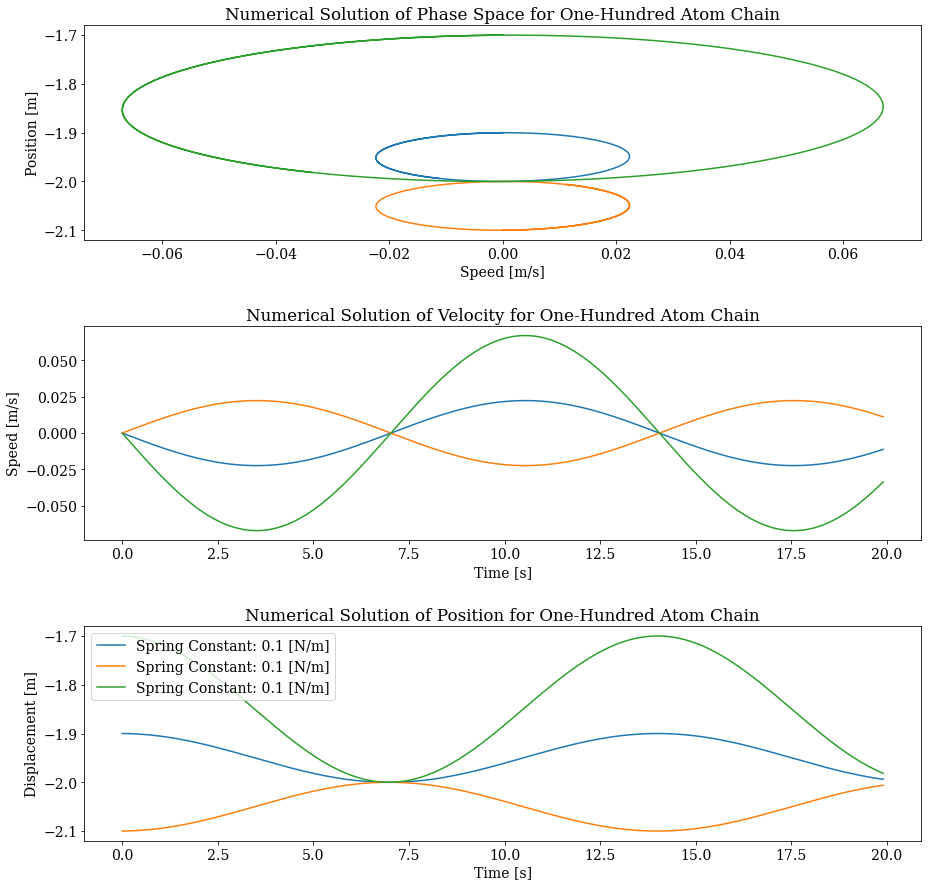

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

def calculate_eqofmotion(atoms, spring_constant, eq_len, time):
    """ Calculates the equation of motion using a form of Euler's Method. Returns
    the first atoms force, position, and velocity. It mostly matches the
    Newtonian formulation.
    """
    # atoms should be R3 position vectors
    # spring constant and eq_len are constants
    # time is an array of incremented time values. Assume dt is constant.
    pos1 = atoms[0][0]
    pos2 = atoms[0][1]

    # arrays to be returned
    spring_force = []
    velocity1 = [(pos1*0)] # have zero vectors with the same format
    velocity2 = [(pos2*0)]
    position1 = [pos1]
    position2 = [pos2]
    # key variables
    mass = 1.0 # assume mass = 1
    dt = time[1] - time[0] # time step
    # save previous values
    old_pos1, old_pos2 = pos1, pos2
    old_vel1, old_vel2 = pos1*0, pos2*0 # assume no initial velocity
    # find initial spring force
    spr_len = np.linalg.norm(old_pos2 - old_pos1)
    # assume spr_dir_hat must be constant.
    spr_dir_hat = (old_pos2 - old_pos1) / spr_len # vector is towards pos2
    spr_force = spring_constant * (spr_len - eq_len) * (-1)*spr_dir_hat
    spring_force.append(spr_force)
        
    for _ in time[1::1]:
        # recalculate spring force from previous positions
        spr_len = np.linalg.norm((old_pos2 - old_pos1))
        spr_dir_hat = (old_pos2 - old_pos1) / spr_len # vector is towards pos2
        spr_force = spring_constant * (spr_len - eq_len) * (-1)*spr_dir_hat
        
        # Calculate the force contribution from the other atoms.
        cont_spring_force = []
        for cont_next_pos1, cont_next_pos2 in atoms[1::1]:
            cont_spr_len = np.linalg.norm(np.array(cont_next_pos1) - np.array(cont_next_pos2))
            cont_spr_dir_hat = (np.array(cont_next_pos1) - np.array(cont_next_pos2))/cont_spr_len
            cont_spr_force = spring_constant * (cont_spr_len - eq_len) * (+1)*cont_spr_dir_hat
            cont_spring_force.append(cont_spr_force)
        
        # Calculate the force on the first atom due to the second + all other connected atoms.
        total_force = np.array(spr_force) + np.array(cont_spring_force)
        spring_force = np.append(spring_force, total_force)
        
        # recalculate velocity from old spring force 
        new_vel1 = old_vel1 + (-1)*spr_force / mass * dt
        new_vel2 = old_vel2 + (+1)*spr_force / mass * dt 
        velocity1.append(new_vel1)
        velocity2.append(new_vel2)
        
        # recalculate new position from old velocity 
        new_pos1 = old_pos1 + new_vel1 * dt
        new_pos2 = old_pos2 + new_vel2 * dt
        position1.append(new_pos1)
        position2.append(new_pos2)
        
        # update old vars 
        old_vel1, old_vel2 = new_vel1, new_vel2
        old_pos1, old_pos2 = new_pos1, new_pos2
    
    return spring_force, velocity1, position1, spring_constant

def produce_graphs(numerical, time):
    # Change font, and size.
    plt.rcParams['font.family'] = 'serif'
    plt.rcParams['font.serif'] = ['Times New Roman'] + plt.rcParams['font.serif']
    plt.rcParams.update({
        'font.size': 14,
    })
    
    fig = plt.figure(figsize=(15,15))
    gp = GridSpec(3,1, fig, hspace=0.4)
    
    # Set preliminary information
    time_label = "Time [s]"
    ax00 = plt.subplot(gp[0])
    ax00.set_title('Numerical Solution of Phase Space for One-Hundred Atom Chain')
    ax00.set_ylabel('Position [m]')
    ax00.set_xlabel("Speed [m/s]")
    ax01 = plt.subplot(gp[1])
    ax01.set_title('Numerical Solution of Velocity for One-Hundred Atom Chain')
    ax01.set_ylabel('Speed [m/s]')
    ax01.set_xlabel(time_label)
    ax02 = plt.subplot(gp[2])
    ax02.set_title('Numerical Solution of Position for One-Hundred Atom Chain')
    ax02.set_ylabel('Displacement [m]')
    ax02.set_xlabel(time_label)
    
    label_str = "Spring Constant: {} [N/m]"
    # Numerical Solution first.
    for _, vel, pos, scon in numerical:
        pos = np.array([p[0] for p in pos])
        
        vel = np.array([v[0] for v in vel])
        
        ax00.plot(vel, pos,
        label=label_str.format(scon))
        ax01.plot(time, vel, 
        label=label_str.format(scon))
        ax02.plot(time, pos, 
        label=label_str.format(scon))
    
    plt.legend(loc='upper left')
    plt.show()
    
# Define time interval
t = list(np.arange(0, 20, 0.1))
# Define the atoms. Create a 100 body linear chain seperated by 1 angstrom each.
a = 1.0
atoms = [([-2*a, 0, 0], [0, 0, 0])]

for i in range(1, 100):
    atoms.append(([i*a, 0, 0], [(i+1)*a, 0, 0]))

first_atoms = np.array(atoms)
second_atoms = np.array(atoms)
third_atoms = np.array(atoms)

eq_len = np.linalg.norm(first_atoms[0][0] - first_atoms[0][1])

# Displace the first atom for three distinct test cases.
first_atoms[0][0] = [-2*a+0.1, 0, 0]
second_atoms[0][0] = [-2*a-0.1, 0, 0]
third_atoms[0][0] = [-2*a+0.3, 0, 0]

numerical = [
         calculate_eqofmotion(first_atoms, 0.1, eq_len, t)
        ,calculate_eqofmotion(second_atoms, 0.1, eq_len, t)
        ,calculate_eqofmotion(third_atoms, 0.1, eq_len, t)
]

produce_graphs(numerical, t)

# 3D Visualization of a Face Centered Cubic Atomic Structure
Graphs are cool, but 3D is more interesting, and it shows a more relatable image to our world. The following code produces a face centered cubic structure of atoms in $\mathbb{R}^3$. The red atom represents the atom that is being perturbed (nudged/displaced). For the following code, I nudge it to the right of the scene. As you can see, the atoms in the crystal structure begin to oscillate back and forth. As a forward, most of the code has been hidden/abstracted behind a class hierarchy for my own sanity. The differential equation is solved via the method explained under 'Newtonian Derivation'

In [2]:
from cell_structure import CellStructure
from render_cell import RenderCell
import numpy as np
import vpython as vp

def spring_solve(cell, initial_displacement, threshold):
    renderer = RenderCell(cell, threshold)
    renderer.plot_supplimentary_information()
    
    renderer.change_atom_pos(initial_displacement)
    
    renderer.render()

def generate_fcc(cell, a, num_of_atoms=100):
    # Outer corners (back)
    cell.place_atom('Si', vp.vector(a/2, a/2., a/2))
    cell.place_atom('Si', vp.vector(a/2, -a/2.,a/2))
    cell.place_atom('Si', vp.vector(-a/2, a/2, a/2))
    cell.place_atom('Si', vp.vector(-a/2,-a/2,a/2))
    
    # Outer corners (front)
    cell.place_atom('Si', vp.vector(a/2,a/2,-a/2))
    cell.place_atom('Si', vp.vector(a/2,-a/2,-a/2))
    cell.place_atom('Si', vp.vector(-a/2,a/2,-a/2))
    cell.place_atom('Si', vp.vector(-a/2,-a/2,-a/2))
    
    # Faces
    cell.place_atom('Si', vp.vector(a/2,0., 0.))
    cell.place_atom('Si', vp.vector(-a/2,0., 0.))
    cell.place_atom('Si', vp.vector(0.,0.,-a/2))
    cell.place_atom('Si', vp.vector(0.,0.,a/2))
    cell.place_atom('Si', vp.vector(0.,a/2,0.))
    cell.place_atom('Si', vp.vector(0.,-a/2,0.))

# Run program
a = 3.57 #angstroms

# Useless for now.
cell = [[a/2, 0, 0],
        [0, a/2, 0],
        [0, 0, a/2]]

cell_structure = CellStructure(np.array(cell))

generate_fcc(cell_structure, a)

# Initial condition
initial_displacement = vp.vector(0.5,0,0)

spring_solve(cell_structure, initial_displacement, a)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# Conclusion
Why do this? Spring based atomistic solids are easy to calculate. As you can see in the original derivation, the force equation is rather simplistic. The Lagrangian formulation is also rather simplistic (not included due to time constraints). In a language faster than python, one could dramatically scale up the number of atoms. The time complexity remains $\mathscr{O}(n!)$. This tells us that the execution time increases dramatically as the number of atoms increases. However, this cost is considerably less compared to that if we had to solve the Schr&ouml;dinger equation instead.